# Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
import numpy as np
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from pandas_profiling import ProfileReport

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
df = pd.concat([train_df, test_df])

# EDA

In [3]:
train_df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
train_df.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [5]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
train_df.corr()

Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   
Transported  -0.075026    -0.244611   0.046566      0.010141 -0.221131   

                VRDeck  Transported  
Age           0.101007    -0.075026  
RoomService  -0.019581    -0.244611  
FoodCourt     0.227995     0.046566  
ShoppingMall -0.007322     0.010141  
Spa           0.153821    -0.221131  
VRDeck        1.000000    -0.207075  
Transported  -0.207075     1.000000

(array([8.156e+03, 2.540e+02, 6.500e+01, 1.700e+01, 9.000e+00, 9.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0. ,  1432.7,  2865.4,  4298.1,  5730.8,  7163.5,  8596.2,
        10028.9, 11461.6, 12894.3, 14327. ]),
 <BarContainer object of 10 artists>)

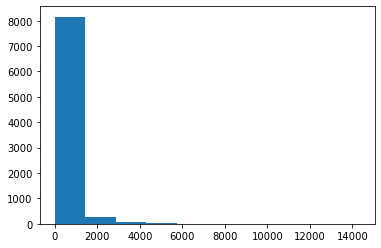

In [7]:
plt.hist(train_df['RoomService'])

# Feature Engineering

## Categorical Variables

In [8]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
constant_imputer = SimpleImputer(strategy='constant', fill_value=-99999)
frequent_imputer = SimpleImputer(strategy='most_frequent')

In [9]:
df[['PassengerGroup', 'PassengerNumber']] = df['PassengerId'].str.split('_', 1, expand=True)

In [10]:
df['PassengerGroup'] = df['PassengerGroup'].astype(int)
df['PassengerNumber'] = df['PassengerNumber'].astype(int)

In [11]:
df[['CabinDeck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)

In [12]:
cd = pd.get_dummies(df['CabinDeck'], prefix = 'cd')
df = pd.concat([df, cd], axis=1)

In [13]:
df['CabinNumber'] = df['CabinNumber'].astype(float)

In [14]:
cs = pd.get_dummies(df['CabinSide'], prefix = 'cs', drop_first=True)
df = pd.concat([df, cs], axis=1)

In [15]:
hp = pd.get_dummies(df['HomePlanet'], prefix = 'hp')
df = pd.concat([df, hp], axis=1)

In [16]:
le = LabelEncoder()

In [17]:
df[['CryoSleep', 'VIP']] = frequent_imputer.fit_transform(df[['CryoSleep', 'VIP']])
df['CryoSleep']= le.fit_transform(df['CryoSleep'])

In [18]:
dest = pd.get_dummies(df['Destination'], prefix = 'dest')
df = pd.concat([df, dest], axis=1)

In [19]:
df['HomePlanet']= le.fit_transform(df['HomePlanet'])
df['CabinDeck']= le.fit_transform(df['CabinDeck'])
df['CabinSide']= le.fit_transform(df['CabinSide'])
df['VIP']= le.fit_transform(df['VIP'])
df['Destination']= le.fit_transform(df['Destination'])

In [20]:
df['Transported']= le.fit_transform(df['Transported'])

In [21]:
df[['FirstName', 'LastName']] = df['Name'].str.split(' ', 1, expand=True)

In [22]:
df['NameLength'] = df['Name'].str.len()
df['FirstNameLength'] = df['FirstName'].str.len()
df['LastNameLength'] = df['LastName'].str.len()


In [23]:
df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Nulls

In [24]:
train = df[df['PassengerId'].isin(train_df['PassengerId'])]
test = df[df['PassengerId'].isin(test_df['PassengerId'])]
train = train.copy()
test = test.copy()

In [25]:
train[['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNumber', 'CabinSide', 'Destination', 'VIP']] = frequent_imputer.fit_transform(train[['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNumber', 'CabinSide', 'Destination', 'VIP']])
test[['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNumber', 'CabinSide', 'Destination', 'VIP']] = frequent_imputer.transform(test[['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNumber', 'CabinSide', 'Destination', 'VIP']])

train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = median_imputer.fit_transform(train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])
test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = median_imputer.transform(test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])

train[['FirstNameLength', 'LastNameLength', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = mean_imputer.fit_transform(train[['FirstNameLength', 'LastNameLength', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])
test[['FirstNameLength', 'LastNameLength', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = mean_imputer.transform(test[['FirstNameLength', 'LastNameLength', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])


# Numerical Variables

In [26]:
ss = StandardScaler()

In [27]:
train[['PassengerGroup', 'PassengerNumber', 'FirstNameLength', 'LastNameLength', 'CabinNumber']] = ss.fit_transform(train[['PassengerGroup', 'PassengerNumber', 'FirstNameLength', 'LastNameLength', 'CabinNumber']])
test[['PassengerGroup', 'PassengerNumber', 'FirstNameLength', 'LastNameLength', 'CabinNumber']] = ss.transform(test[['PassengerGroup', 'PassengerNumber', 'FirstNameLength', 'LastNameLength', 'CabinNumber']])


In [28]:
log = PowerTransformer()

In [29]:
train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalSpent']] = log.fit_transform(train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalSpent']])
test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalSpent']] = log.transform(test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalSpent']])

In [30]:
train.corr()['Transported']


HomePlanet            0.107755
CryoSleep             0.460132
Destination          -0.104817
Age                  -0.085662
VIP                  -0.037261
RoomService          -0.354961
FoodCourt            -0.194208
ShoppingMall         -0.236285
Spa                  -0.357400
VRDeck               -0.338478
Transported           1.000000
PassengerGroup        0.021491
PassengerNumber       0.066390
CabinDeck            -0.109925
CabinNumber          -0.044012
CabinSide             0.093319
cd_A                 -0.002623
cd_B                  0.144733
cd_C                  0.108193
cd_D                 -0.034046
cd_E                 -0.097965
cd_F                 -0.087753
cd_G                  0.016269
cd_T                 -0.014568
cs_S                  0.101455
hp_Earth             -0.169019
hp_Europa             0.176916
hp_Mars               0.019544
dest_55 Cancri e      0.108722
dest_PSO J318.5-22    0.000092
dest_TRAPPIST-1e     -0.094700
NameLength            0.005057
FirstNam

## Feature Selection

Best score [0.8177113283496262]: all features except Name derived vars.

In [31]:
train = train[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'PassengerNumber', 'CabinNumber', 'cd_B', 'cd_C', 'cd_D', 'cd_E', 'cd_F', 'cd_G', 'cd_T', 'cs_S', 'hp_Earth', 'hp_Europa', 'dest_55 Cancri e', 'dest_TRAPPIST-1e', 'TotalSpent', 'Transported']]
test = test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'PassengerNumber', 'CabinNumber', 'cd_B', 'cd_C', 'cd_D', 'cd_E', 'cd_F', 'cd_G', 'cd_T', 'cs_S', 'hp_Earth', 'hp_Europa', 'dest_55 Cancri e', 'dest_TRAPPIST-1e', 'TotalSpent', 'Transported']]

In [32]:
profile = ProfileReport(train, title = 'Spaceship Titanic')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
y = train['Transported']
X = train.drop('Transported', axis=1)

# Applying ML Models

In [34]:
gbc = GradientBoostingClassifier(random_state=0)
lr = LogisticRegression(random_state=0)
xgboost = xgb.XGBClassifier(random_state=0)
ab = AdaBoostClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
svc = SVC(kernel = 'rbf', random_state=0)
cb = CatBoostClassifier(verbose=0, random_state=0)
lgbm = LGBMClassifier(silent=True, random_state=0)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [36]:
gbc.fit(X_train, y_train)
lr.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
ab.fit(X_train, y_train)
rf.fit(X_train, y_train)
svc.fit(X_train, y_train)
cb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

/home/matheus/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(random_state=0, silent=True)

In [37]:
coef = pd.Series(lr.coef_[0], X.columns).sort_values()
print(coef)

TotalSpent         -0.630861
cd_G               -0.521299
Spa                -0.410641
VRDeck             -0.405589
VIP                -0.364699
RoomService        -0.337001
cd_E               -0.251640
hp_Earth           -0.178249
dest_TRAPPIST-1e   -0.113460
Age                -0.073548
PassengerNumber    -0.021811
cd_T               -0.000035
PassengerGroup      0.014985
CabinNumber         0.106347
cd_F                0.183962
dest_55 Cancri e    0.251550
cd_D                0.253348
ShoppingMall        0.258205
FoodCourt           0.332596
cd_B                0.493956
cs_S                0.509432
cd_C                0.703527
CryoSleep           0.820445
hp_Europa           0.880556
dtype: float64


In [38]:
y_pred_gbc = gbc.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_xgboost = xgboost.predict(X_test)
y_pred_ab = ab.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_cb = cb.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)

In [39]:
print(confusion_matrix(y_test, y_pred_gbc))

[[662 201]
 [156 720]]


In [40]:
print(confusion_matrix(y_test, y_pred_lr))

[[651 212]
 [225 651]]


In [41]:
print(confusion_matrix(y_test, y_pred_xgboost))

[[699 164]
 [179 697]]


In [42]:
print(confusion_matrix(y_test, y_pred_ab))

[[636 227]
 [129 747]]


In [43]:
print(confusion_matrix(y_test, y_pred_rf))

[[722 141]
 [192 684]]


In [44]:
print(confusion_matrix(y_test, y_pred_svc))

[[677 186]
 [224 652]]


In [45]:
print(confusion_matrix(y_test, y_pred_cb))

[[687 176]
 [148 728]]


In [46]:
print(confusion_matrix(y_test, y_pred_lgbm))

[[686 177]
 [156 720]]


In [47]:
accuracy_score(y_test, y_pred_gbc)

0.7947096032202415

In [48]:
accuracy_score(y_test, y_pred_lr)

0.7487061529614721

In [49]:
accuracy_score(y_test, y_pred_xgboost)

0.8027602070155262

In [50]:
accuracy_score(y_test, y_pred_ab)

0.7952846463484762

In [51]:
accuracy_score(y_test, y_pred_rf)

0.8085106382978723

In [52]:
accuracy_score(y_test, y_pred_svc)

0.7642323174238068

In [53]:
accuracy_score(y_test, y_pred_cb)

0.8136860264519838

In [54]:
accuracy_score(y_test, y_pred_lgbm)

0.8085106382978723

# Hyperparameter Tuning

In [55]:
params = {'eta':[0], 'max_depth': [5, 7, 8], 'gamma': [2], 'min_child_weight': [9, 10, 11], 'colsample_bytree': [0.6]}

In [56]:
#gsxgb = GridSearchCV(xgboost, param_grid=params, scoring='accuracy', cv=5, verbose=3)
gsxgb = xgb.XGBClassifier(eta=0, max_depth=5, gamma=2, min_child_weight=9, colsample_bytree=0.6)

In [57]:
gsxgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False, eta=0,
              eval_metric=None, feature_types=None, gamma=2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [58]:
#gsxgb.best_score_

In [59]:
#gsxgb.best_params_

# Model Stacking

In [91]:
estimators = [('gbc', gbc), ('xgboost', xgboost), ('cb', cb), ('lgbm', lgbm)]

In [92]:
stacked = StackingClassifier(estimators=estimators, passthrough=False)

In [93]:
stacked.fit(X_train, y_train)

/home/matheus/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/matheus/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/matheus/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/hom

StackingClassifier(estimators=[('gbc',
                                GradientBoostingClassifier(random_state=0)),
                               ('xgboost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importan...
                                              max_bin=256, max_cat_threshold=64,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=6,
                                              max_leaves=0, min_child_weight=1,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=0,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=0, ...)),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x7f9498f98cd0>),
                               ('lgbm',
                                LGBMClassifier(random_state=0, silent=True))],
                   passthrough=True)

In [94]:
y_pred_stacked = stacked.predict(X_test)

In [95]:
accuracy_score(y_test, y_pred_stacked)

0.8142610695802185

In [85]:
0.816561242093157

0.816561242093157

In [86]:
print(confusion_matrix(y_test, y_pred_stacked))

[[678 185]
 [134 742]]


# Preparing submission

In [87]:
y_submission = pd.DataFrame(stacked.predict(test.drop('Transported', axis=1)), columns=['Transported'])

In [88]:
y_submission['PassengerId'] = test_df['PassengerId']
y_submission = y_submission[['PassengerId', 'Transported']]

In [89]:
y_submission['Transported'].replace({0: 'False', 1: 'True'}, inplace=True)

In [90]:
y_submission.to_csv('output/spaceship_titanic.csv', index=False)